In [3]:
import numpy as np
from qiskit import QuantumCircuit, transpile, assemble
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Operator, Statevector
import matplotlib.pyplot as plt
from math import sqrt

In [17]:
BASES = ['zs', 'xs']

def generate_random(length, bit_probability, basis_probability):
    bits = np.random.choice([0, 1], size=length, p=[1-bit_probability, bit_probability])
    bases = np.random.choice(BASES, size=length, p=[1-basis_probability, basis_probability])
    return bits, bases

def encode_bit(bit, basis):
    qc = QuantumCircuit(1, 1)
    
    if bit == 1:
        qc.x(0)
        
    if(basis == 'xs'):
        qc.h(0)
        
    return qc

def eve_measure(qc):#, basis):
    basis_change = (1/sqrt(2)) * np.array([
        [1, 1],
        [1, -1]
    ])
    U = Operator(basis_change)
    qc.unitary(U, 0)
    qc.measure(0, 0)
    
    backend = Aer.get_backend('qasm_simulator')
    
    result = backend.run(qc, shots=1).result()
    
    counts = result.get_counts()
    measured_bit = int(max(counts, key=counts.get)) 
    
    return measured_bit

def eve_encode(measured_bit):
    qc = QuantumCircuit(1, 1)
    if measured_bit == 1:
        qc.x(0)
    basis_change = (1/sqrt(2)) * np.array([
        [1, 1],
        [1, -1]
    ])
    U = Operator(basis_change.conj().T)
    qc.unitary(U, 0)
    return qc

def measure_qubit(qc, basis, shots=1):
    if basis == 'xs':
        qc.h(0)
    qc.measure(0, 0)
    
    backend = Aer.get_backend('qasm_simulator')
    result = backend.run(qc, shots=shots).result()
    
    counts = result.get_counts()

    measured_bit = int(counts.most_frequent())
    return measured_bit

def bb84_protocol(length, bit_probability, alice_basis_probability, bob_basis_probability): #theta):
    alice_bits, alice_bases = generate_random(length, bit_probability, alice_basis_probability)
    alice_qubits = [encode_bit(bit, basis) for bit, basis in zip(alice_bits, alice_bases)]
    
    eve_bits = [eve_measure(qc) for qc in alice_qubits]
    eve_qubits = [eve_encode(bit) for bit in eve_bits]
    
    bob_bases = np.random.choice(BASES, length, p=[1-bob_basis_probability, bob_basis_probability])
    bob_bits = [measure_qubit(qc, basis) for qc, basis in zip(eve_qubits, bob_bases)]
    
    alice_key = [alice_bits[i] for i in range(length) if alice_bases[i] == bob_bases[i]]
    bob_key = [bob_bits[i] for i in range(length) if alice_bases[i] == bob_bases[i]]
    
    return alice_key, alice_bits, alice_bases, eve_bits, bob_bases, bob_bits, bob_key

def eve_check(alice_key, bob_key, sample_size):
    sample_size = min(sample_size, len(alice_key))
    
    sample_indices = np.random.choice(len(alice_key), size=sample_size, replace=False)
    sample_alice = [alice_key[i] for i in sample_indices]
    sample_bob = [bob_key[i] for i in sample_indices]
    
    error_count = sum([1 for a, b in zip(sample_alice, sample_bob) if a != b])
    error_rate_sample = error_count / sample_size
    
    remaining_alice_key = [bit for i, bit in enumerate(alice_key) if i not in sample_indices]
    remaining_bob_key = [bit for i, bit in enumerate(bob_key) if i not in sample_indices]
    
    remaining_error_count = sum([1 for a, b in zip(remaining_alice_key, remaining_bob_key) if a != b])
    remaining_error_rate = remaining_error_count / (len(alice_key) - sample_size) if len(alice_key) > sample_size else 0
    
    return error_rate_sample, remaining_error_rate


key_length = 70
bit_probability = 0.5
alice_basis_probability = 0.5
bob_basis_probability = 0.5
#eve_theta = np.pi / 4
sample_size = 20

alice_key, alice_bits, alice_bases, eve_bits, bob_bases, bob_bits, bob_key = bb84_protocol(key_length, bit_probability, alice_basis_probability, bob_basis_probability)
#print("Alice's Key:", alice_key)
print("Alice's bits:", alice_bits)
#print("Alice's Bases:", alice_bases)
print("Eve's Key:", eve_bits)
#print("Bob's Bases:", bob_bases)
print("Bob's bits:", bob_bits)
#print("Bob's Key:", bob_key)
print("Key Length:", len(alice_key))

error_rate, remaining_error_rate= eve_check(alice_key, bob_key, sample_size)
print("Sample Error Rate:", error_rate)
print("Remaining Error Rate:", remaining_error_rate)
print("k/n =", len(alice_key)/key_length)

Alice's bits: [1 0 0 1 0 1 0 0 0 0 1 1 1 1 0 0 0 1 1 0 1 0 0 1 1 0 1 0 0 0 0 0 0 1 0 0 1
 1 0 0 1 1 1 0 0 1 1 0 0 0 0 0 0 1 1 0 0 1 0 1 1 1 1 1 1 1 1 0 1 1]
Eve's Key: [1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1]
Bob's bits: [1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0]
Key Length: 31
Sample Error Rate: 0.3
Remaining Error Rate: 0.2727272727272727
k/n = 0.44285714285714284


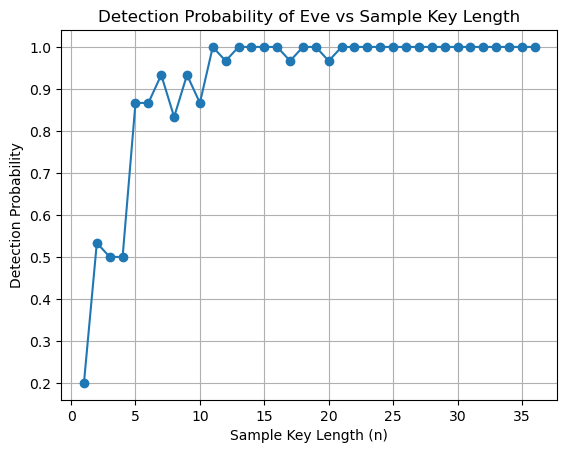

In [19]:
def detect_eve_probability(key_length, bit_probability, alice_basis_probability, bob_basis_probability, sample_size, iterations):
    detection_count = 0
    
    for _ in range(iterations):
        alice_key, alice_bits, alice_bases, eve_bits, bob_bases, bob_bits, bob_key = bb84_protocol(key_length, bit_probability, alice_basis_probability, bob_basis_probability) #eve_theta)
        error_rate_sample, remaining_error_rate = eve_check(alice_key, bob_key, sample_size)
        if error_rate_sample > 0: 
            detection_count += 1
    
    detection_probability = detection_count / iterations
    return detection_probability

sample_sizes = range(1, 37)  
iterations = 30

detection_probabilities = [detect_eve_probability(key_length, bit_probability, alice_basis_probability, bob_basis_probability, n, iterations) for n in sample_sizes]

plt.plot(sample_sizes, detection_probabilities, marker='o')
plt.xlabel('Sample Key Length (n)')
plt.ylabel('Detection Probability')
plt.title('Detection Probability of Eve vs Sample Key Length')
plt.grid(True)
plt.show()